<a href="https://colab.research.google.com/github/Robot-Wealth/trader-tales/blob/master/quant-techniques/Convert_Binary_Signals_to_Continuous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Don't Get Fancy: Simple Ways to Convert Binary Signals to Continuous Ones

This notebook is in response to a question about making binary signals continuous, specifically trying to apply fancy techniques like exponential smoothing to retrofit their signal.

Here's the main point:

You don't need fancy techniques to convert binary signals to continuous ones. In fact, you can tie yourself in knots trying to apply these techniques without understanding the underlying effect.

Instead, if you go back to first principles and focus on understanding the edge, the right approach will naturally reveal itself.

Let me show you how using a crypto trend example.

## The problem with binary signals

You've seen them everywhere. "If price is above the 20-day moving average, be long. If it's below, be short."

That's a binary signal. It's either ON or OFF. And while it works (sort of), it's missing a ton of potential insights.

Why? Three big reasons:

1. There's nothing magical about crossing a threshold. Markets don't fundamentally change the second price crosses a moving average.

2. A binary signal throws away valuable information. Markets give us precious little signal as it is - don't waste it!

3. It creates weridly aggressive and abrupt trading. Flipping positions every time you cross a line is hard to justify.

## A better way: Think about the edge first

Instead of jumping straight to complicated quant techniques, start by trying to understand the underlying edge.

Our signal is trying to measure trend in crypto. So start by asking: "Why would crypto trend?"

A plausible hypothesis is that FOMO drives prices, amplified by leverage and the lack of a firm anchor for fair value.

Next, how do we measure trend? Simple - it's when positive returns are followed by more positive returns, and negative returns lead to more negative returns.

A moving average is a reasonable measure of this. When price is above its moving average, that tells us price has gone up in the recent past. But that only gives us two states - above or below.

Let's start by looking at this binary signal, then we'll come up with a better way.

## Load libraries and data

In [1]:
# load libraries
if (!require(pacman)) install.packages("pacman")
library(pacman)
p_load(tidyverse, roll, patchwork)
p_load_gh("RWLab/tlaqData", dependencies = FALSE, update = FALSE)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

# load data
data(btc)
head(btc)

Loading required package: pacman

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘pacman’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppParallel’, ‘RcppArmadillo’



roll installed

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


patchwork installed



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpjSfcco/remotesb75982a8ef/RWLab-tlaqData-254a5ed/DESCRIPTION’ ... OK
* preparing ‘tlaqData’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘tlaqData_1.5.tar.gz’



Date,Ticker,Close,MarketCapUSD,log_return,fwd_log_return,fwd_simple_return
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-08-18,BTC,4113.75,70206129858,-0.052801728,0.006355936,0.006376177
2017-08-19,BTC,4139.98,70206129858,0.006355936,0.007220283,0.007246412
2017-08-20,BTC,4169.98,68107644316,0.007220283,-0.031394307,-0.030906623
2017-08-21,BTC,4041.10,67025089751,-0.031394307,-0.009722696,-0.009675583
2017-08-22,BTC,4002.00,65051698864,-0.009722696,0.027650168,0.028035982
2017-08-23,BTC,4114.20,68521256729,0.027650168,0.050252088,0.051536143


In [2]:
# construct binary signal
btc <- btc %>%
  mutate(ma = roll_mean(Close, 20)) %>%
  mutate(price_ma_binary = case_when(Close >= ma ~ 1, TRUE ~ -1)) %>%
  na.omit()

tail(btc)

Date,Ticker,Close,MarketCapUSD,log_return,fwd_log_return,fwd_simple_return,ma,price_ma_binary
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025-05-27,BTC,109027.0,2.180199e+12,-0.001498230,-0.015028671,-0.014916304,105751.6,1
2025-05-28,BTC,107400.7,2.140342e+12,-0.015028671,-0.013797260,-0.013702514,105970.7,1
2025-05-29,BTC,105929.1,2.122167e+12,-0.013797260,-0.018702622,-0.018528814,106127.9,-1
2025-05-30,BTC,103966.3,2.083731e+12,-0.018702622,0.006323078,0.006343111,106146.3,-1
2025-05-31,BTC,104625.8,2.076729e+12,0.006323078,0.008436221,0.008471907,106187.9,-1
2025-06-01,BTC,105512.2,2.071975e+12,0.008436221,0.001735828,0.001737335,106320.7,-1


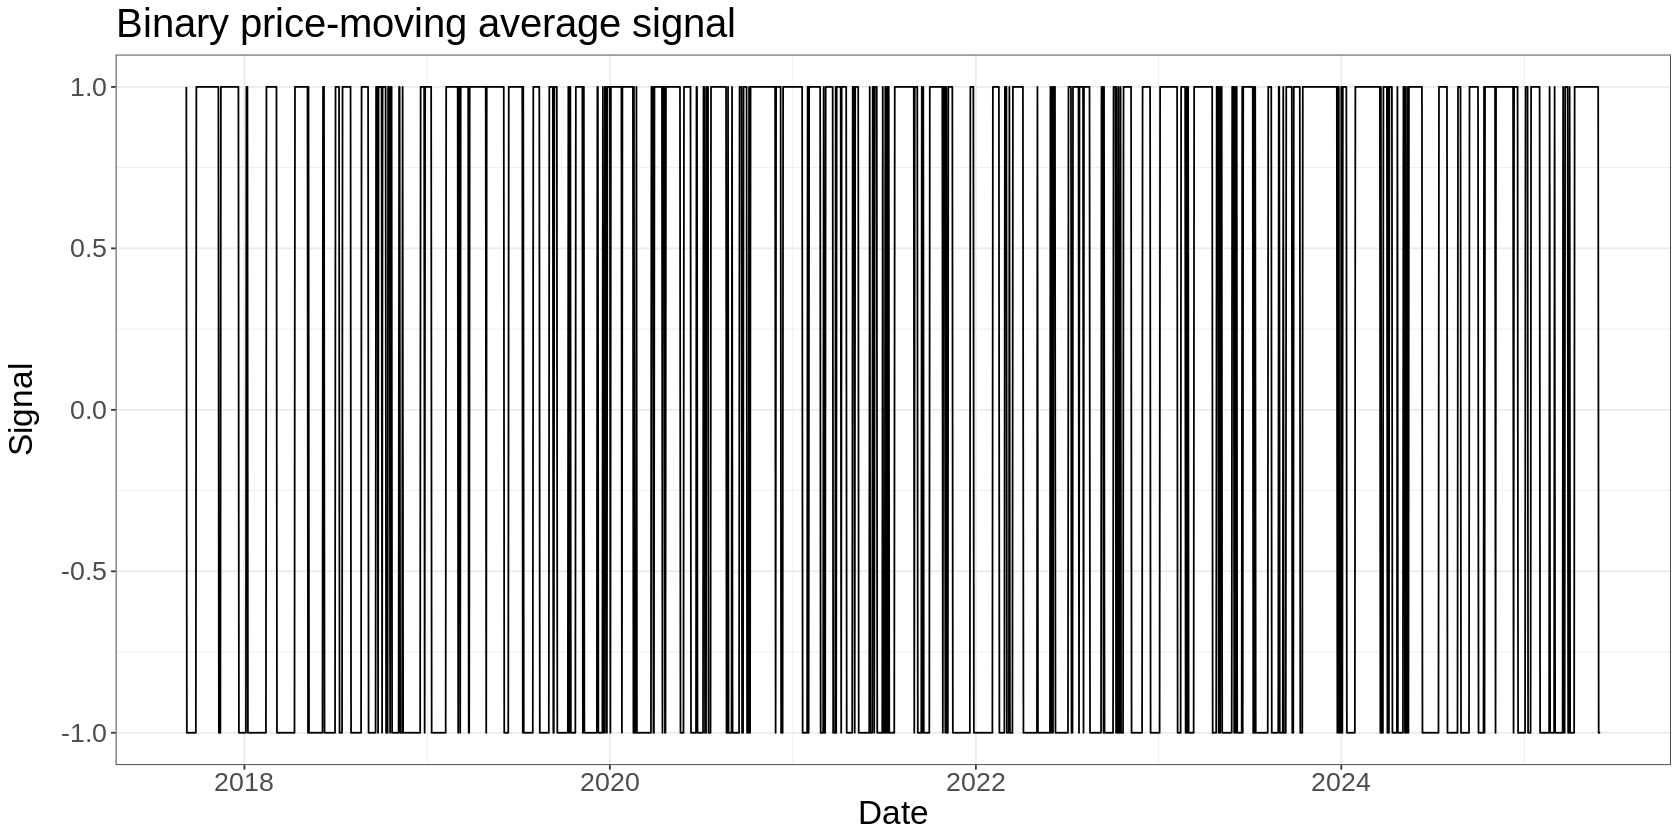

In [3]:
btc %>%
  ggplot(aes(x = Date, y = price_ma_binary)) +
  geom_line() +
  labs(
   y = "Signal",
   title = "Binary price-moving average signal"
  )

Warning message in scale_x_discrete(limits = c(-1, 1)):
“Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


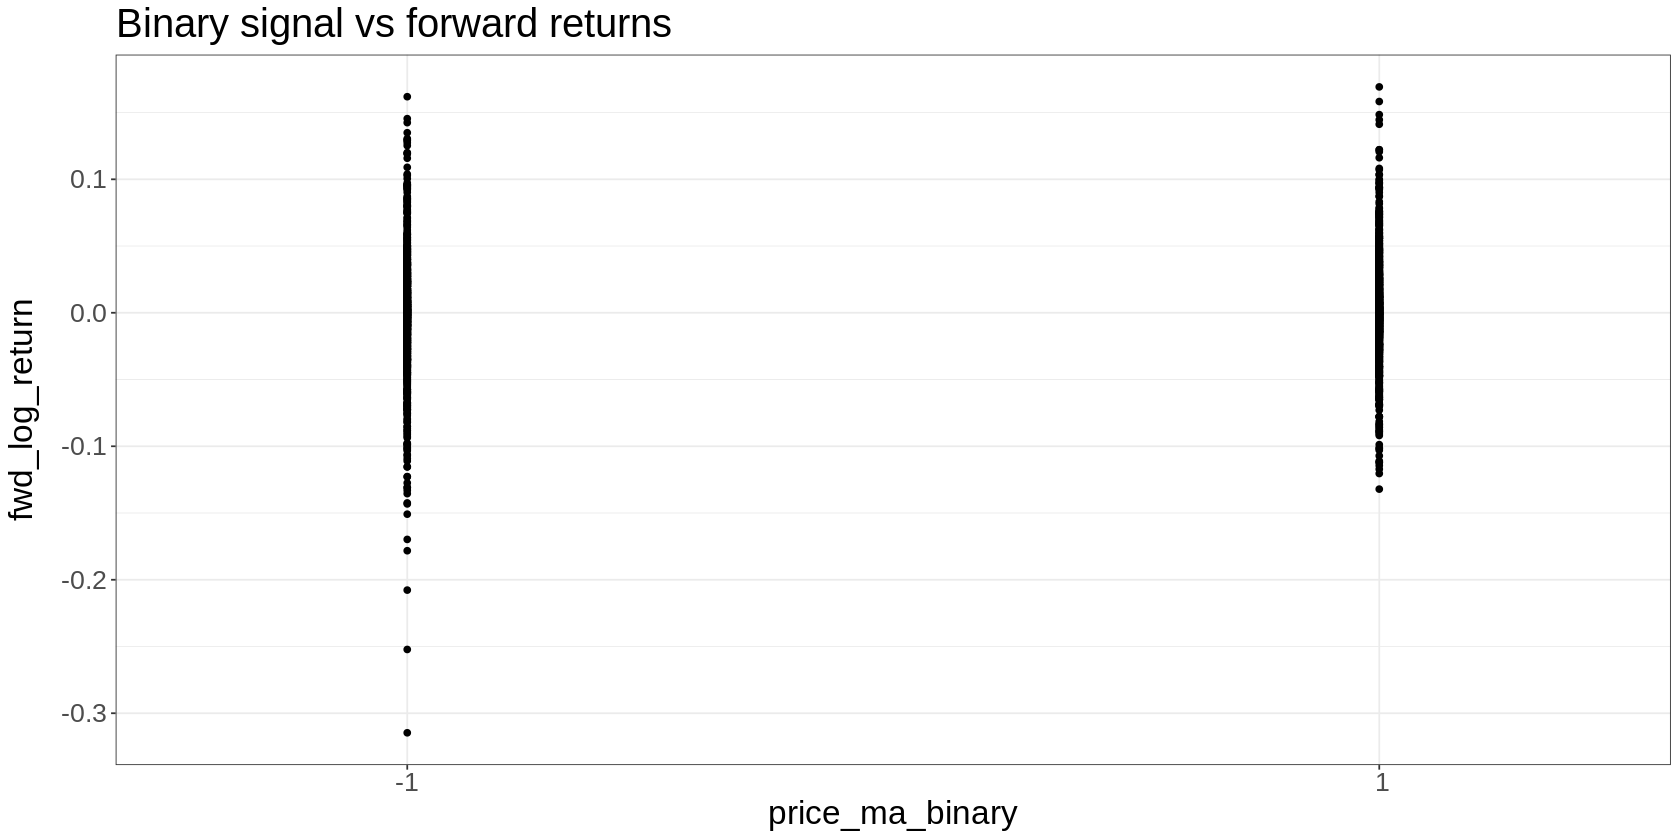

In [4]:
btc %>%
  ggplot(aes(x = price_ma_binary, y = fwd_log_return)) +
  geom_point() +
  scale_x_discrete(limits = c(-1, 1)) +
  labs(
    title = "Binary signal vs forward returns"
  )

That's useful, in that it shows that a simple binary trend measure noisily discriminates between high and low future returns - returns look higher on average when the signal is "on" than when it's "off".

But it leaves huge gaps in our understanding.

In particular, what happens in the middle of the distribution?

Remember research is all about understanding an effect first and foremost.

If you start with the mindset of trying to understand the effect, you'll nearly always end up in the right place.

Here, we have a big and obvious gap in our understanding. So with our "understanding first" mindset, we think about how we can fill it.

How can we measure trend in a way that fills in the middle of that distribution? That is, how can we use every data point available to us, rather than just the points at which price crossed the moving average?

This is a key point: in seeking to understand an edge, you always want to think about making the best use of your data that you can. Constructing a binary signal is, in essence, throwing away a huge chunk of your data. And financial data is already in short supply, so don't waste it!

Here's a slight adjustment to our trend measurement that takes care of this:

Instead of the binary above/below signal, *calculate the ratio of price and the moving average*.

```R
# binary signal (old way)
price_ma_binary = case_when(Close >= ma ~ 1, TRUE ~ -1)

# continuous signal (better way)
price_ma = Close/ma
```
This wasn't some clever trick I had up my sleeve. It emerged naturally from asking, "How can I measure the strength of the trend at every point, not just when it crosses a threshold?"

When price is further above the moving average, the ratio will be higher (stronger uptrend). When it's below, the ratio will be lower (stronger downtrend).

But the real benefit is that this will give you a value for every single day. Furthermore, the signal can take on any value (as opposed to only two), which means we can do more interesting analysis.

Congratulations. You've just created a continuous signal without any fancy math, just by thinking clearly about the problem.

Let's see what this looks like:

In [5]:
btc <- btc %>%
  mutate(price_ma = Close/ma)

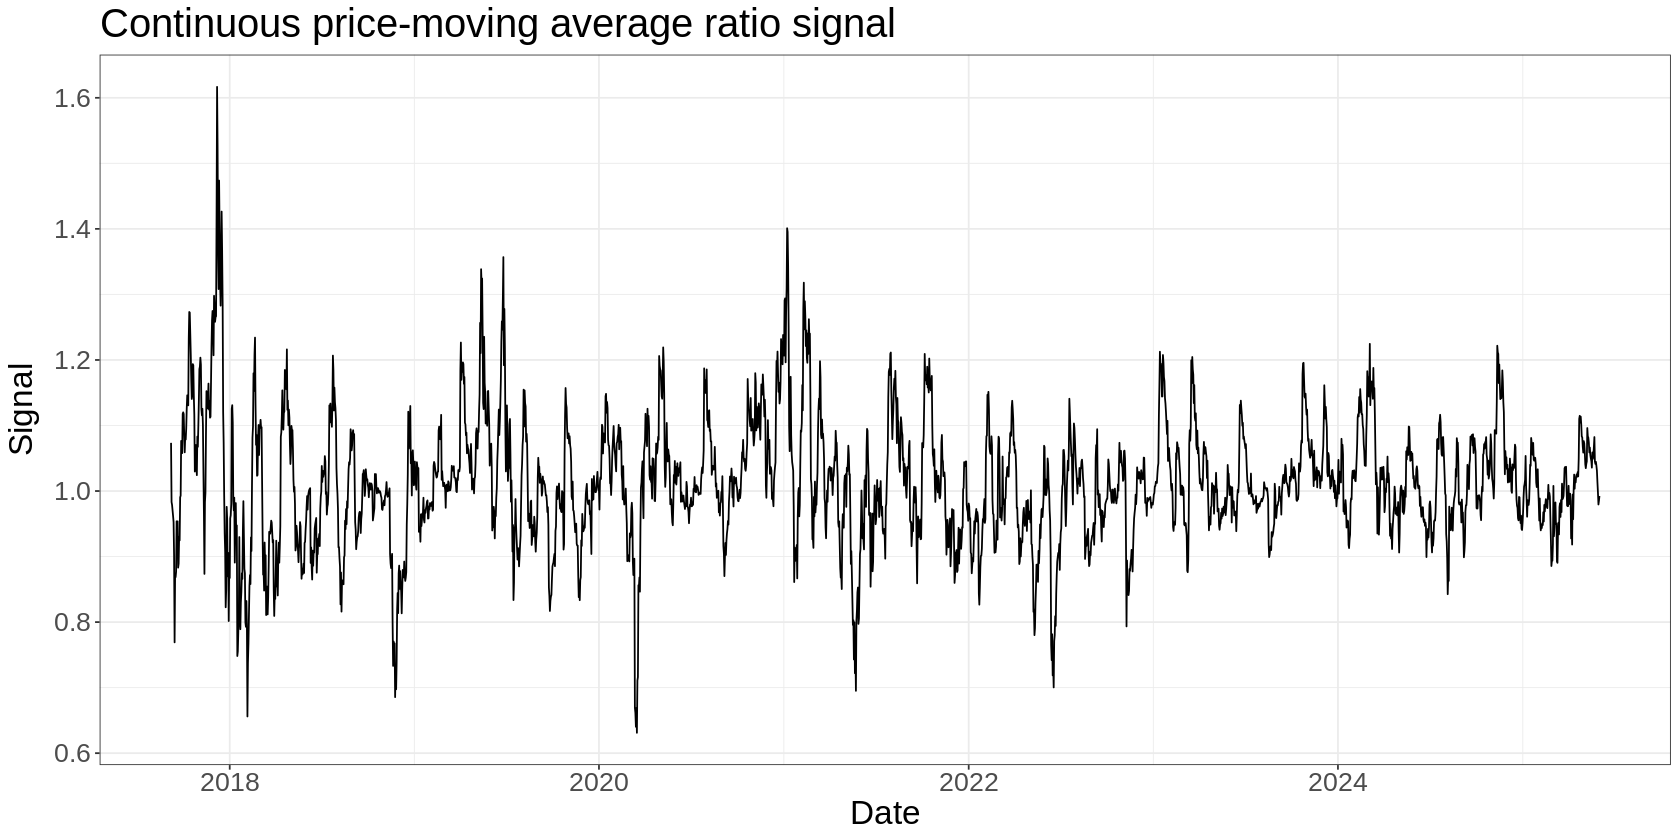

In [6]:
btc %>%
  ggplot(aes(x = Date, y = price_ma)) +
  geom_line() +
   labs(
    y = "Signal",
    title = "Continuous price-moving average ratio signal"
  )

It's a good idea to always plot these things and look for obvious changes.

In this case, we might say that the signal was more volatile earlier in the history than recently, so we might want to vol-scale it. We'll gloss over that for now.

Let's now look at a scatter plot of our continuous signal:

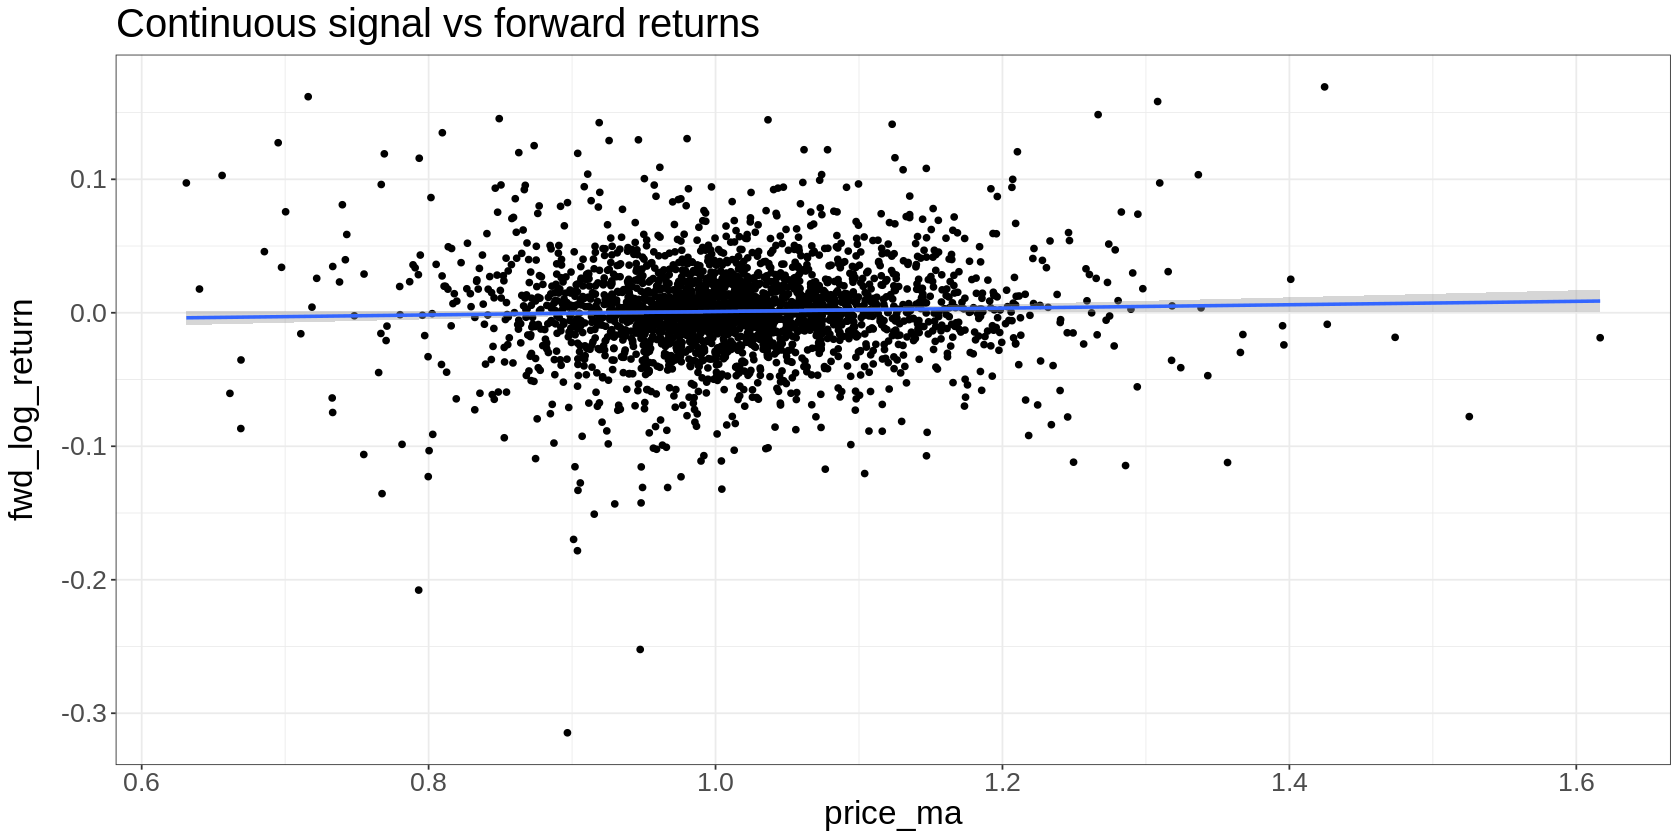

In [7]:
btc %>%
  ggplot(aes(x = price_ma, y = fwd_log_return)) +
  geom_point() +
  geom_smooth(method = "lm", formula = y~x) +
  labs(
    title = "Continuous signal vs forward returns"
  )

This has filled in the middle of the distribution and told us some interesting things we couldn't infer from the binary signal analysis:
- The relationship is roughly linear - as our trend signal increases, so do future returns (on average)
- It's very noisy (welcome to trading!)

We now understand more than we did. And this gives us clues for how we might trade this:
- Since the relationship is roughly linear, we might scale position size by the magnitude of the feature
- Since it's very noisy (everything is), we set proper expectations around short-term return variance.

At this point, we might want to collapse our data into something more discrete - this helps us highlight average effects, but the downside is it hides the variance. It's just another view on our effect.

Here, we split our signal values into 10 equal buckets. The bottom 10% of values go into bucket 1, the next 10% in bucket 2, and so on.

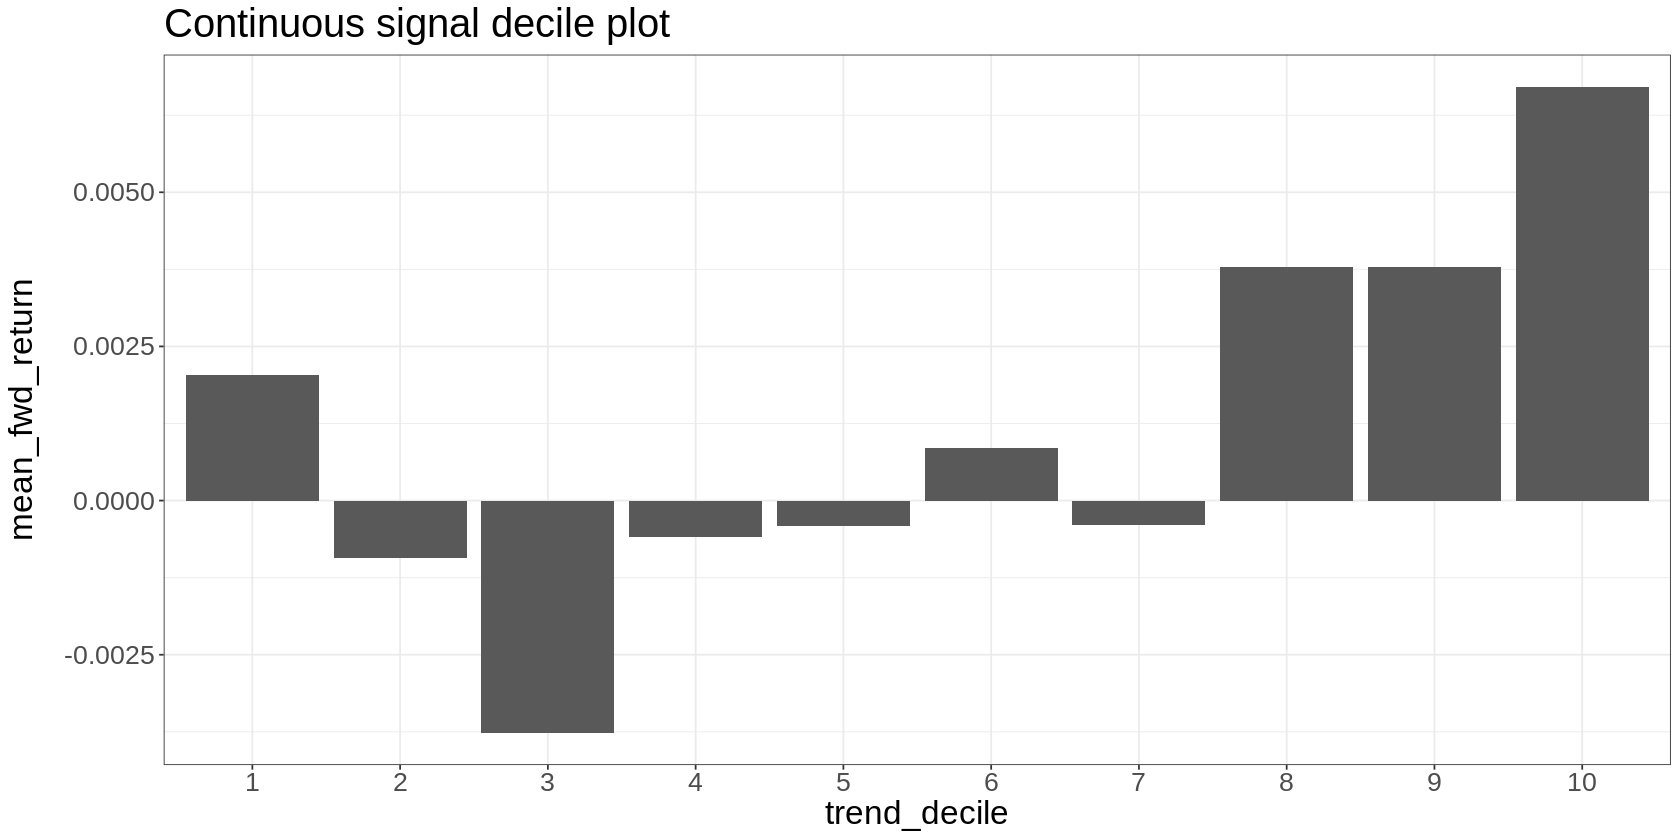

In [8]:
btc %>%
  mutate(trend_decile = ntile(price_ma, 10)) %>%
  group_by(trend_decile) %>%
  summarise(mean_fwd_return = mean(fwd_log_return)) %>%
  mutate(trend_decile = factor(trend_decile)) %>%
  ggplot(aes(x = trend_decile,  y = mean_fwd_return)) +
  geom_bar(stat = "identity") +
  labs(
   title = "Continuous signal decile plot"
  )

You can see how this sort of thing highlights average effects that are hard to make out in the scatter plot.

Here we see a noisy and imperfect relationship between the signal bucket and future returns.

We can also see a reversal off extreme negative returns - see the positive return in bucket 1. We might want to include that in our strategy exlicitly, or dig into it as its own thing.

The interesting thing is that we'd never have noticed this if we used the binary signal. But by making better use of our data, the effect starts to reveal itself.

*This insight wasn't the result of clever strategy design. It appeared because I was focused on understanding the data.*

Finally, let's plot a timeseries of cumulative returns to our signal. This looks like a backtest, but it's not - it's just the returns attributed to the signal and doesn't account for costs or real-world trading constraints (for instance you wouldn't hyperactivley trade the signal every single day).

This sort of thing is useful for seeing how the signal performed over time in isolation.

In [12]:
btc %>%
  mutate(trend_decile = ntile(price_ma, 10)) %>%
  group_by(trend_decile) %>%
  # filter(trend_decile == 1) %>%
  summarise(
    min(price_ma), max(price_ma), mean(price_ma)
  )

trend_decile,min(price_ma),max(price_ma),mean(price_ma)
<int>,<dbl>,<dbl>,<dbl>
1,0.6311202,0.9050703,0.8501998
2,0.9052228,0.9482974,0.9287977
3,0.9484752,0.9730071,0.9605907
4,0.9730099,0.9895888,0.9816221
5,0.9896402,1.0067213,0.9983195
6,1.0068014,1.0245761,1.0154931
7,1.0246173,1.0469802,1.0351983
8,1.0472874,1.0782536,1.0626418
9,1.0782608,1.1307372,1.1014359


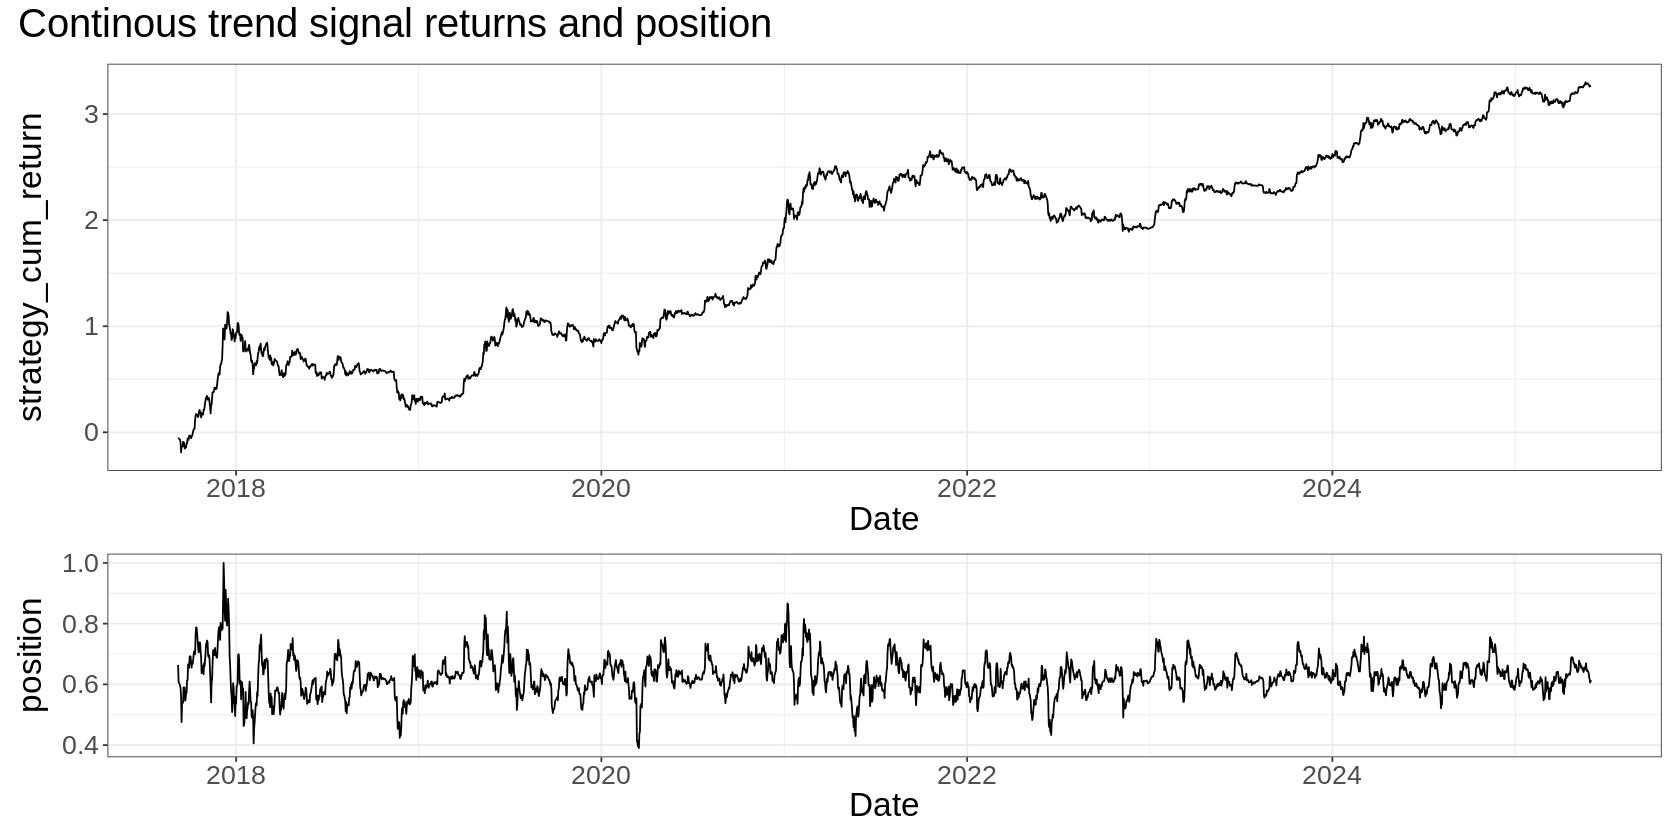

In [17]:
strat_df <- btc %>%
  mutate(position = price_ma/max(abs(price_ma))) %>%
  mutate(strategy_return = position * fwd_simple_return) %>%
  mutate(strategy_cum_return = cumsum(strategy_return))

return_plot <- strat_df %>%
  ggplot(aes(x = Date, y = strategy_cum_return)) +
  geom_line()

pos_plot <- strat_df %>%
  ggplot(aes(x = Date, y = position)) +
  geom_line()

return_plot / pos_plot + plot_layout(heights = c(2,1)) + plot_annotation(title = "Continous trend signal returns and position")

In [19]:
cont_sd <- strat_df %>%
  summarise(sigma = sd(strategy_return)) %>% pull(sigma)
cont_sd

[1] 0.02224816

Here's what the binary signal looks like:

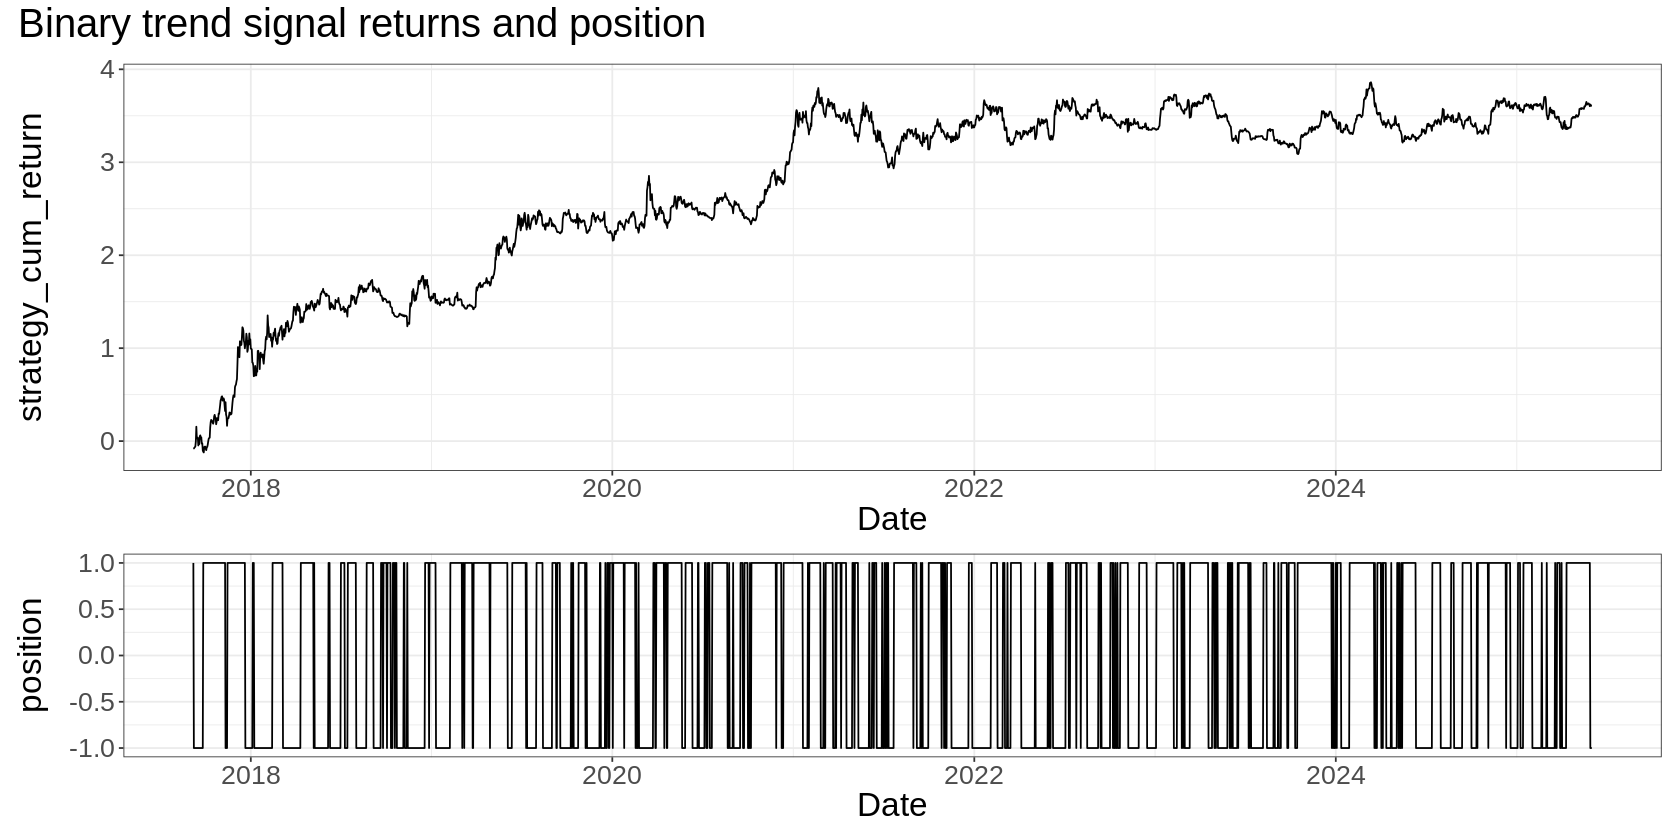

In [21]:
strat_df <- btc %>%
  mutate(position = price_ma_binary) %>%
  mutate(strategy_return = position * fwd_simple_return) %>%
  mutate(strategy_cum_return = cumsum(strategy_return))

return_plot <- strat_df %>%
  ggplot(aes(x = Date, y = strategy_cum_return)) +
  geom_line()

pos_plot <- strat_df %>%
  ggplot(aes(x = Date, y = position)) +
  geom_line()

return_plot / pos_plot + plot_layout(heights = c(2,1)) + plot_annotation(title = "Binary trend signal returns and position")

In [22]:
bin_sd <- strat_df %>%
  summarise(sigma = sd(strategy_return)) %>% pull(sigma)
bin_sd

[1] 0.03571736

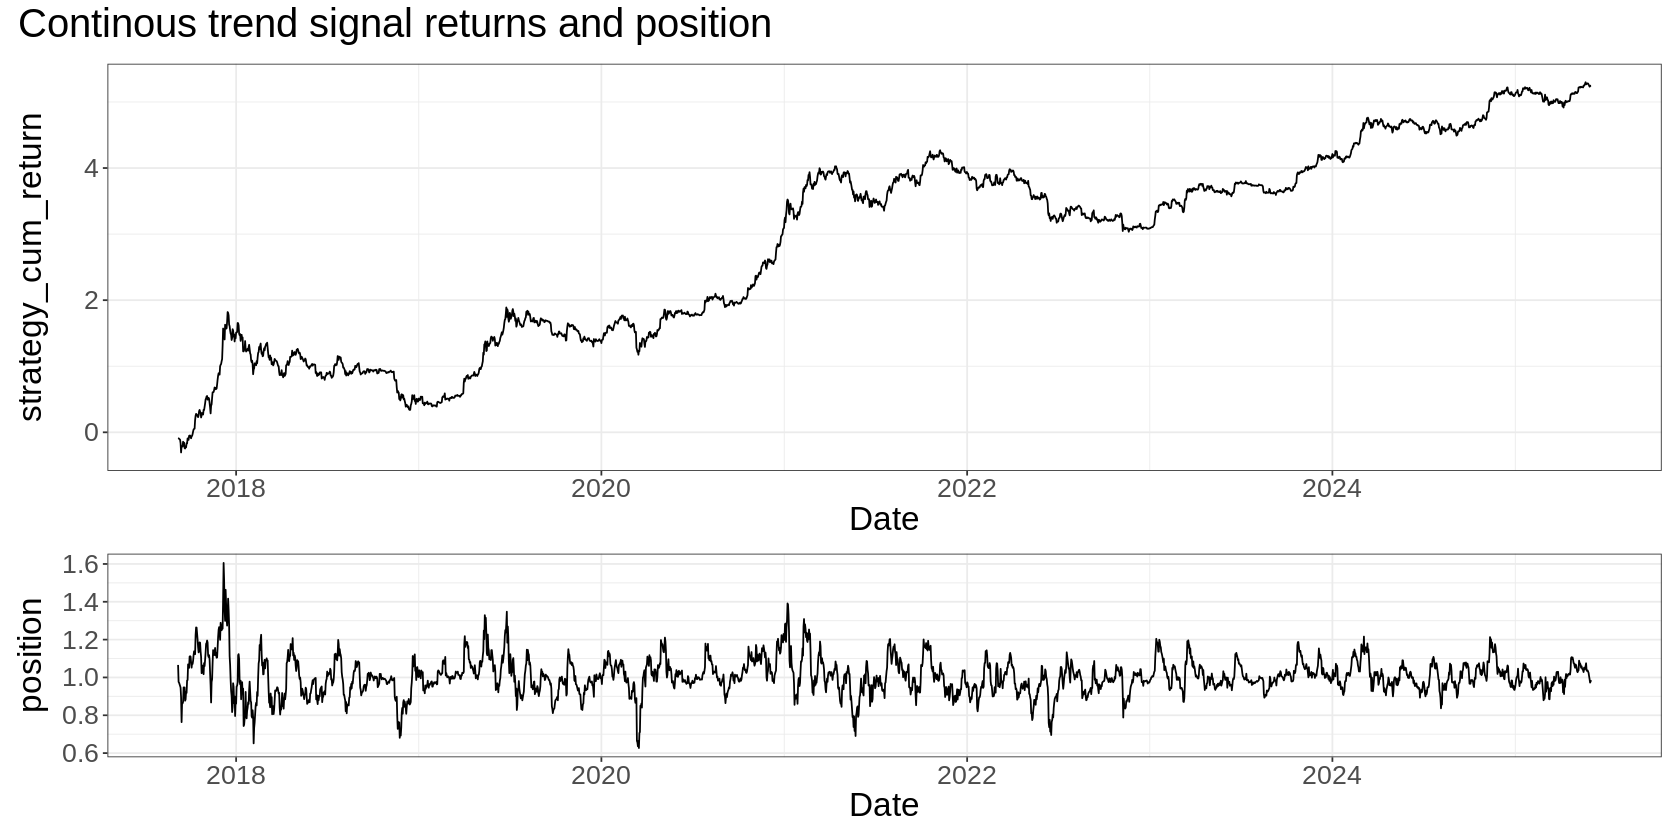

In [23]:
# scale continuous signal returns to same vol as binary signal
strat_df <- btc %>%
  mutate(position = bin_sd/cont_sd * price_ma/max(abs(price_ma))) %>%
  mutate(strategy_return = position * fwd_simple_return) %>%
  mutate(strategy_cum_return = cumsum(strategy_return))

return_plot <- strat_df %>%
  ggplot(aes(x = Date, y = strategy_cum_return)) +
  geom_line()

pos_plot <- strat_df %>%
  ggplot(aes(x = Date, y = position)) +
  geom_line()

return_plot / pos_plot + plot_layout(heights = c(2,1)) + plot_annotation(title = "Continous trend signal returns and position")

## Summary

It's easy to get caught up in fancy techniques or jump straight to strategy design. But that's getting things backward.

The better approach:

- Focus on understanding your edge first
- Use all your data, not just some of it
- Let the right strategy emerge from your understanding

When you adopt this mindset, you'll find that:

- You waste less time on complex solutions that aren't needed
- You discover nuances in your edge that you'd otherwise miss
- The optimal trading approach becomes obvious rather than forced

This approach deepens your understanding of how your edge actually works. And that understanding often leads to refinements and entirely new trading ideas that you'd never discover otherwise.